In [ ]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import math
from sklearn.preprocessing import MinMaxScaler
from datetime import date

import matplotlib.pyplot as plt

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.metrics import RootMeanSquaredError

from sklearn.metrics import r2_score

from typing import Union, List, Any, Callable

In [ ]:
###   Data cleaning and preprocessing


#   Get stock data

def set_source (source : str = "yahoo", start_date : (str, date) = "2020-01-01", end_date : (str, date) = date.today ()):
    '''I want to separate the source and date parameters from the selection of the stock to examine.
    The purpose is to select the data source (e.g. yahoo) and the start and end dates for the data.
    '''
    def select_stock (stock : str) -> pd.DataFrame:
        '''Select the stock ticker for the desired stock to be examined.
        Examples:
        T = AT&T Inc.
        APPL = Apple Inc.
        '''
        if source == "stooq":
            return pdr.DataReader (stock, data_source = source, start = start_date, end = end_date)[:: -1]
            #   Stooq sorts the data starting from the end date to start. So, the dataframe needs to be reversed,
            #   hence, [:: -1]
        else:
            return pdr.DataReader (stock, data_source = source, start = start_date, end = end_date)
    return select_stock   #   remember to return result of the sub-function. Otherwise there will be a NoneType error.



#   Select closing price data

def get_closing_price (stock_dataframe : pd.DataFrame) -> pd.DataFrame:
    '''The closing stock price is the only price necessary going forward.'''
    global dataset
    dataset = pd.DataFrame (stock_dataframe["Close"])
    #   dataset is global because the data is needed in a later function
    #   So, rather than reutrn the dataset through each function, it is easier
    #   to make it global and access it when needed later.

    return dataset   #   return a dataframe instead of a series
                                                    #   an alternative method is stockDataframe.filter (['Close'])


#   Visualising closing stock price

def visualise_closing (closing_stock_dataframe : pd.DataFrame) -> None:
    '''A visual summary of the data, showing the closing price of the stock over time.

    End date of COVID-19 based on removal of Canada's removal of border measures as stated on the Government of Canada website
    "COVID-19: Canada's response" : https://www.canada.ca/en/public-health/services/diseases/2019-novel-coronavirus-infection/canadas-reponse.html#ta
    '''

    label_position = closing_stock_dataframe.max ().round ().iloc[0].astype ('int') + 2   #   varies postion of label according values in the data

    plt.figure (figsize = (16, 8))
    plt.plot (closing_stock_dataframe["Close"])
    plt.xlabel ('Date', fontsize = 18)
    plt.ylabel ('Closing Price, $USD', fontsize = 18)
    plt.axvspan (xmin = date (2020, 3, 15), xmax = date (2022, 10, 1), color = "red", alpha = 0.5)
    plt.text (x = date (2020, 3, 17), y = label_position, s = "COVID-19", fontsize = 16)
    plt.show ()



#   Convert dataframe to numpy array

def convert_to_numpy_array (closing_stock_df : pd.DataFrame) -> np.ndarray:
    return closing_stock_df.values



#   Get training and testing data

def set_size_of_training_data (percentage : float = 0.8) -> Callable[[np.ndarray], pd.DataFrame]:
    def get_training_testing_data (dataset : np.ndarray) -> tuple:

        #   Rescale data to values between 0 and 1
        global scaler
        scaler = MinMaxScaler (feature_range = (0, 1))
        #scaledData = scaler.fit_transform (dataset)

        global training_data_len
        training_data_len = math.ceil (len (dataset) * percentage)

        #   Training data
        training_data : np.ndarray = dataset[0: training_data_len, :]

        scaled_training_data : np.ndarray = scaler.fit_transform (training_data)

        x_train : np.ndarray = np.array ([scaled_training_data[i - 60: i, 0] for i in range (60, len (training_data))])
        y_train : np.ndarray = np.array ([scaled_training_data[i, 0] for i in range (60 , len (training_data))])

        x_train_reshaped : np.ndarray = np.reshape (x_train, (x_train.shape[0], x_train.shape[1], 1))

        #   Test data
        test_data : np.ndarray = dataset[training_data_len - 60: , :]

        scaled_test_data : np.ndarray = scaler.transform (test_data)

        y_test : np.ndarray = dataset[training_data_len: , :]
        x_test : np.ndarray = np.array ([scaled_test_data[i - 60: i, 0] for i in range (60, len (test_data))])

        x_test_reshaped : np.ndarray = np.reshape (x_test, (x_test.shape[0], x_test.shape[1], 1))

        return x_train_reshaped, y_train, x_test_reshaped, y_test


    return get_training_testing_data




###   Creating and training the model

#   model function

# def create_the_model (model_layers, batch_size = 1, optimizer = "adam", loss = "mean_squared_error", epochs = 1, metrics = ['mse']):
#     def run_and_evaluate_model (prepared_data):

#         #   Extracting training and test data
#         X_train, y_train, X_test, y_test = prepared_data

#         model = Sequential (
#             model_layers
#         )

#         model.compile (optimizer = optimizer, loss = loss, metrics = metrics)

#         model.fit (X_train, y_train, batch_size = batch_size, epochs = epochs)

#         #   Evaluate the model
#         evals = model.evaluate (X_test, y_test)
#         print (f"The {metrics [0]} of the model is {evals [0]}")
#         print (f"The {metrics [1]} of the model is {evals [1]}")

#         #   Retrieve predictions
#         predictions = scaler.inverse_transform (model.predict (X_test))   #   don't know if this will work.
#         #   recalling the scaler so far down the flow
#         #   scaler might need to be made global

#         return predictions, y_test
#     return run_and_evaluate_model

def create_keras_model (model_layers : list) -> Callable[[tuple], tuple]:
    '''Define the layers of the model.'''
    def prepare_model (prepared_data : tuple) -> tuple:
        '''Create the model and pass the model and data to the compiler.'''
        model = Sequential (model_layers)
        return prepared_data, model
    return prepare_model

def set_model_compiler (optimizer : str = "adam", loss : str = "mean_squared_error", metrics : list = ["mse"]) -> Callable[[tuple], tuple]:
    '''Specify the optimizer and loss function for the model. Also, if using metrics, list the metrics to apply to the model.'''
    def compile_model (data_and_model : tuple) -> tuple:
        '''Compile the model with the optimizer, loss function, and metrics specified.

        The function does not do anything to the data. The data is carried through the function.
        The model object is callibrated to according to the optimizer and loss function selected.
        The desired metrics are also applied to the model.
        '''
        data, model = data_and_model

        model.compile (optimizer = optimizer, loss = loss, metrics = metrics)

        return data, model
    return compile_model

def set_model_batch_and_epoch (batch_size : int = 1, epochs : int = 1) -> Callable[[tuple], tuple]:
    '''Specify the batch size and number of epochs to be used to train the model.'''
    def train_model (data_and_model : tuple) -> tuple:
        '''Train the model with the training data and the compiled model.'''
        data, model = data_and_model
        X_train, y_train, _, _ = data

        model.fit (X_train, y_train, batch_size = batch_size, epochs = epochs)

        return data, model
    return train_model

def calculate_predictions (data_and_model : tuple) -> tuple:
    '''Compute predicted values for the closing stock price for the following day.'''
    data, model = data_and_model
    _, _, X_test, _ = data

    #   Once predictions are determined, the scaler is needed to reverse the rescaling
    #   performed on the data in preparation for training the model.
    predictions : np.ndarray = scaler.inverse_transform (model.predict (X_test))

    return data, predictions, model

def evaluate_model (data_predictions_and_model : tuple) -> np.ndarray:
    '''Evaluate the model using the metrics assigned the model.'''
    data, predictions, model = data_predictions_and_model

    _, _, X_test, y_test = data

    evals = model.evaluate (X_test, y_test, return_dict = True)

    metrics = list (evals.keys ())

    for i in range (1, len (metrics)):
        print (f"The {metrics[i]} of the model is {evals[metrics[i]]}")
    print (f"The adjusted r-squared of the model is {r2_score (y_test, predictions)}")

    return predictions

def plot_prediction_and_y_test (predictions : np.ndarray) -> None:
    '''Fuction to plot the predicted values from the model and compare them to
    the valid values from the dataset.
    Two plots are returned, shows the relation between the predicted values
    and the full dataset. The second plot compares the predicted values to the
    valid values from the dataset.

    Colours of the plot are defined in the matplotlib documentation:
    https://matplotlib.org/3.5.0/users/prev_whats_new/dflt_style_changes.html#colors-color-cycles-and-colormaps
    https://matplotlib.org/stable/gallery/color/named_colors.html
    '''

    train = dataset.iloc [ : training_data_len, :].copy ()   #   [:training_data_len]
    valid = dataset.iloc [training_data_len : , :].copy ()   #   [training_data_len:]

    valid["Predictions"] = predictions

    #   The plot of the full dataset and the predicted values.
    #   The valid values corresponding to the predicted values are coloured
    #   differently from the rest of the dataset.
    plt.figure (figsize = (16, 8))
    plt.title ("Model")
    plt.xlabel ("Date", fontsize = 18)
    plt.ylabel ("Closing Price, $USD", fontsize = 18)
    plt.plot (train["Close"], color = "#1f77b4")
    plt.plot (valid["Close"], color = "#ff7f0e")
    plt.plot (valid["Predictions"], color = "#2ca02c")

    plt.legend (["Train", "Val", "Predictions"], loc = "lower right")
    plt.show ()

    #   Just valid data and predicted values.
    plt.figure (figsize = (16, 8))
    plt.title ("Model")
    plt.xlabel ("Date", fontsize = 18)
    plt.ylabel ("Closing Price, $USD", fontsize = 18)
    plt.plot (valid["Close"], color = "#ff7f0e")
    plt.plot (valid["Predictions"], color = "#2ca02c")
    plt.legend (["Val", "Predictions"], loc = "lower right")
    plt.show ()


def create_pipeline (list_of_functions : list):
    def pipeline (input : str):
        res = input

        for function in list_of_functions:
            res = function (res)

        return res
    return pipeline


In [ ]:
visualise_data_pipeline = create_pipeline ([
    set_source (source = "stooq", start_date = "2010-01-01"),
    get_closing_price,
    visualise_closing
    ]
)

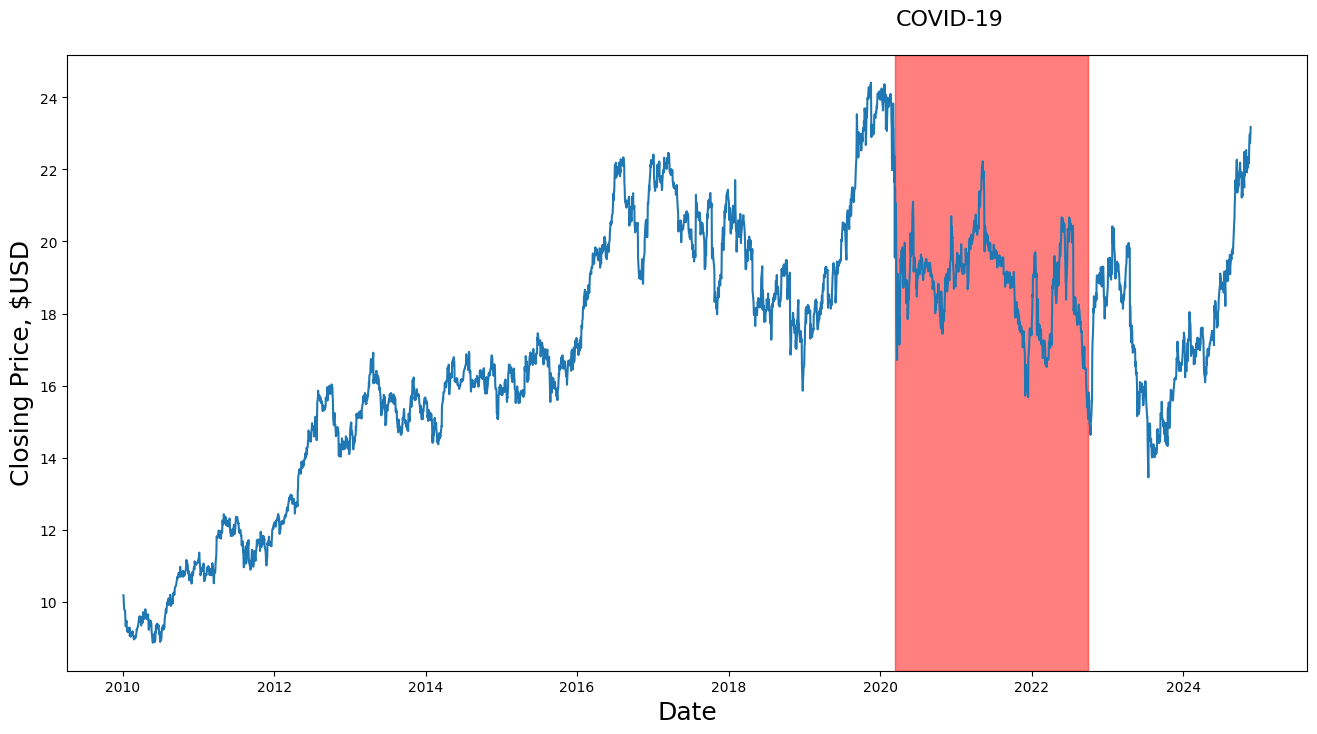

In [ ]:
visualise_data_pipeline ("T")

In [ ]:
print (dataset.head (10))
print (dataset.shape)

               Close
Date                
2010-01-04  10.17500
2010-01-05  10.12010
2010-01-06   9.97591
2010-01-07   9.86174
2010-01-08   9.79078
2010-01-11   9.74171
2010-01-12   9.74171
2010-01-13   9.62314
2010-01-14   9.46213
2010-01-15   9.31577
(3749, 1)


In [ ]:
stock_prediction_pipeline = create_pipeline ([
    set_source (source = "stooq", start_date = "2010-01-01", end_date = "2022-12-31"),
    get_closing_price,
    convert_to_numpy_array,
    set_size_of_training_data (percentage = 0.8),
    create_keras_model (model_layers = [LSTM (50, return_sequences = False, input_shape = (60, 1)), Dense (25), Dense (1)]),
    set_model_compiler (optimizer = "adam", loss = "mean_squared_error", metrics = ["mse", "mae", RootMeanSquaredError ()]),
    set_model_batch_and_epoch (batch_size = 1, epochs = 1),
    calculate_predictions,
    evaluate_model,
    plot_prediction_and_y_test
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2558/2558 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - loss: 0.0034 - mae: 0.0293 - mse: 0.0034 - root_mean_squared_error: 0.0490
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 341.5341 - mae: 18.4561 - mse: 341.5341 - root_mean_squared_error: 18.4793
The mae of the model is 18.129182815551758
The mse of the model is 330.16534423828125
The root_mean_squared_error of the model is 18.170452117919922
The adjusted r-squared of the model is 0.9258806107607417


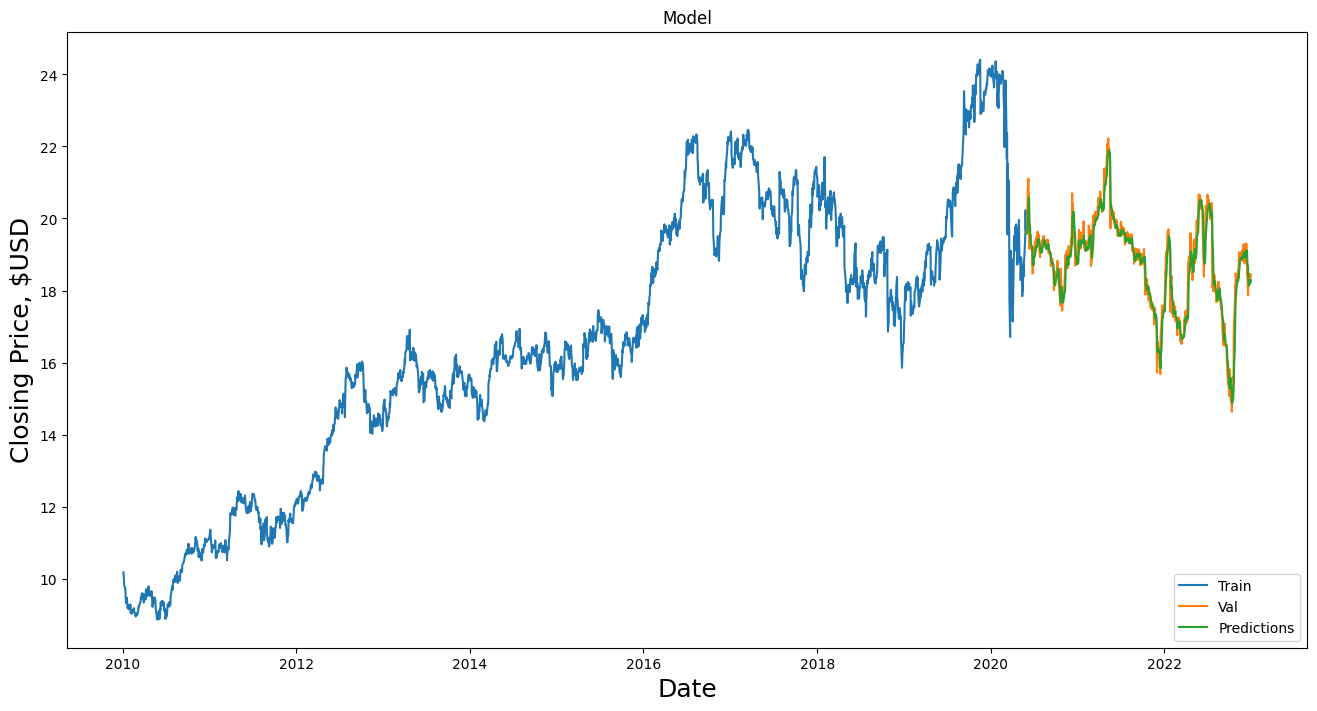

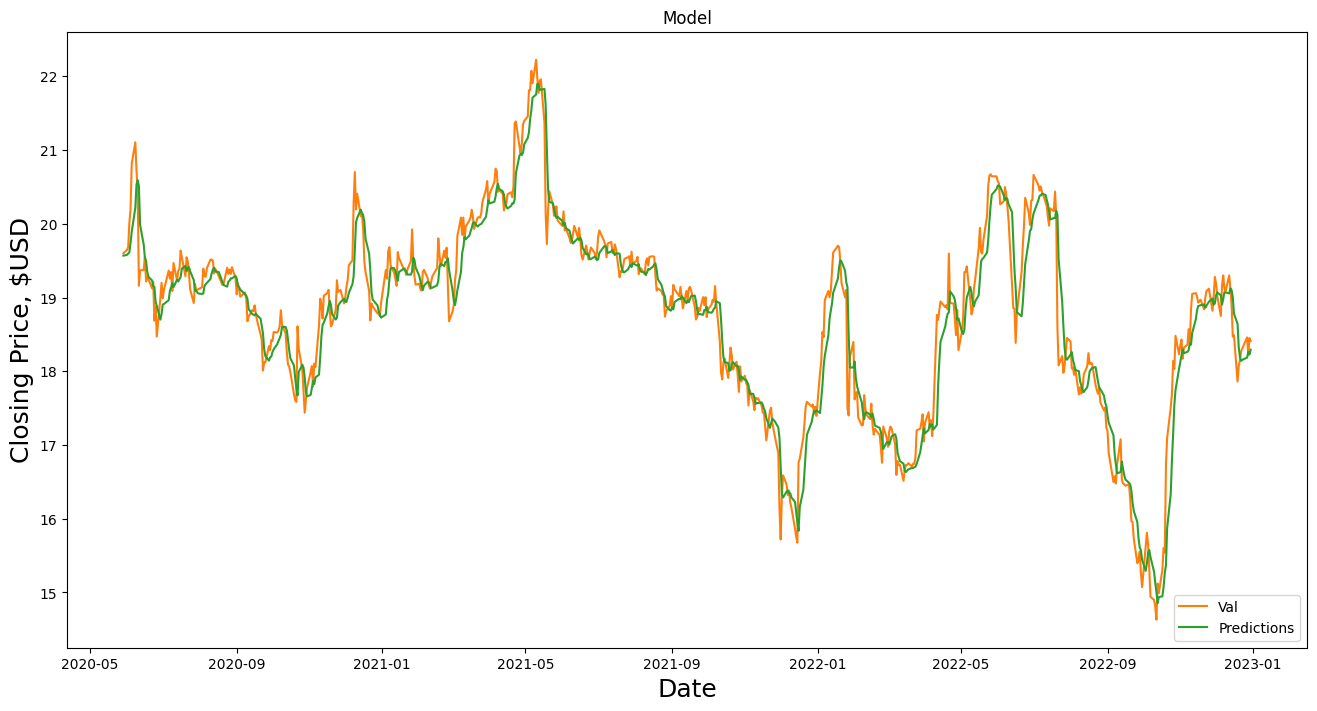

In [ ]:
stock_prediction_pipeline ('T')

In [ ]:
stock_prediction_pipeline_2 = create_pipeline ([
    set_source (source = "stooq", start_date = "2010-01-01"),
    get_closing_price,
    convert_to_numpy_array,
    set_size_of_training_data (percentage = 0.8),
    create_keras_model (model_layers = [LSTM (50, return_sequences = True, input_shape = (60, 1)), LSTM (50, return_sequences = False, input_shape = (60, 1)), Dense (25), Dense (1)]),
    set_model_compiler (optimizer = "adam", loss = "mean_squared_error", metrics = ["mse", "mae", RootMeanSquaredError ()]),
    set_model_batch_and_epoch (batch_size = 1, epochs = 1),
    calculate_predictions,
    evaluate_model,
    plot_prediction_and_y_test
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2940/2940 ━━━━━━━━━━━━━━━━━━━━ 93s 31ms/step - loss: 0.0022 - mae: 0.0314 - mse: 0.0022 - root_mean_squared_error: 0.0440
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 298.3834 - mae: 17.2072 - mse: 298.3834 - root_mean_squared_error: 17.2709
The mae of the model is 17.25043296813965
The mse of the model is 301.0881652832031
The root_mean_squared_error of the model is 17.351892471313477
The adjusted r-squared of the model is 0.9609145416116992


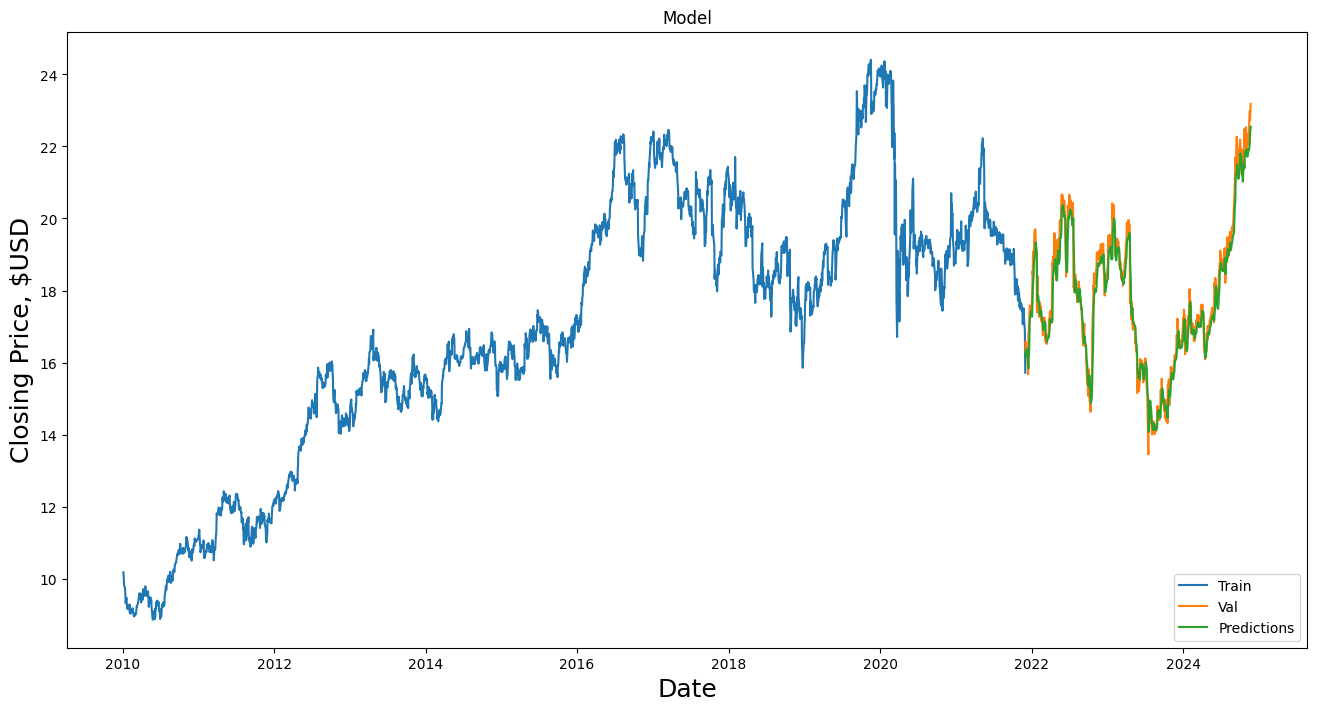

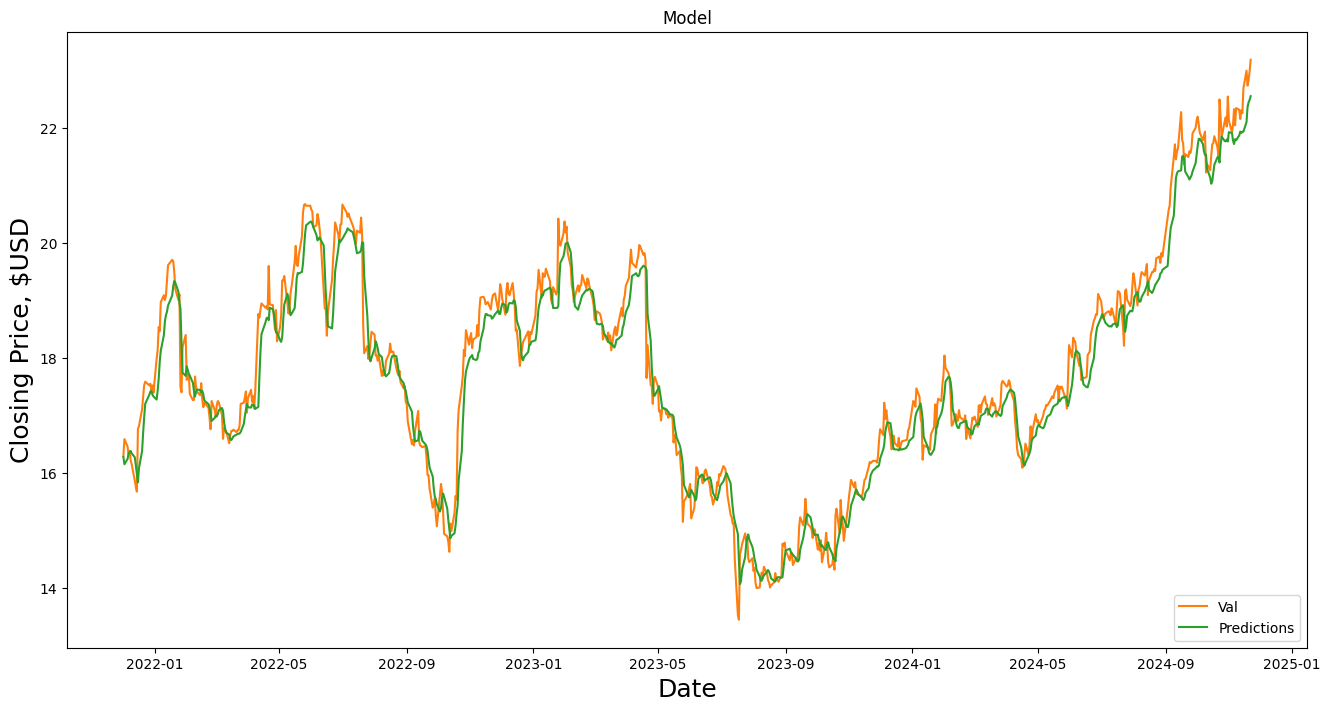

In [ ]:
stock_prediction_pipeline_2 ('T')

In [ ]:
stock_prediction_pipeline_3 = create_pipeline ([
    set_source (source = "stooq", start_date = "2010-01-01"),
    get_closing_price,
    convert_to_numpy_array,
    set_size_of_training_data (percentage = 0.8),
    create_keras_model (model_layers = [LSTM (50, return_sequences = True, input_shape = (60, 1)), LSTM (50, return_sequences = False, input_shape = (60, 1)), Dense (25), Dense (25), Dense (1)]),
    set_model_compiler (optimizer = "adam", loss = "mean_squared_error", metrics = ["mse", "mae", RootMeanSquaredError ()]),
    set_model_batch_and_epoch (batch_size = 1, epochs = 1),
    calculate_predictions,
    evaluate_model,
    plot_prediction_and_y_test
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2940/2940 ━━━━━━━━━━━━━━━━━━━━ 95s 31ms/step - loss: 0.0045 - mae: 0.0409 - mse: 0.0045 - root_mean_squared_error: 0.0599
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 297.1625 - mae: 17.1720 - mse: 297.1625 - root_mean_squared_error: 17.2356
The mae of the model is 17.215147018432617
The mse of the model is 299.85333251953125
The root_mean_squared_error of the model is 17.316272735595703
The adjusted r-squared of the model is 0.9165204824561314


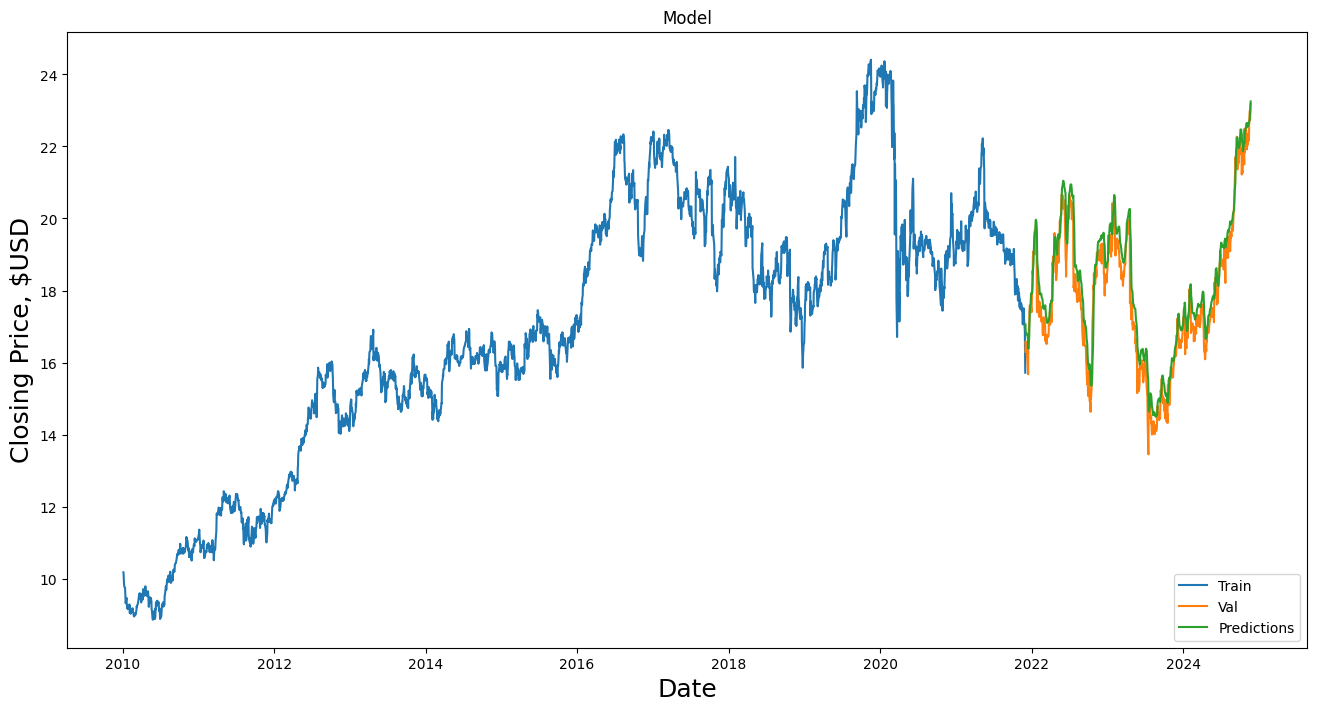

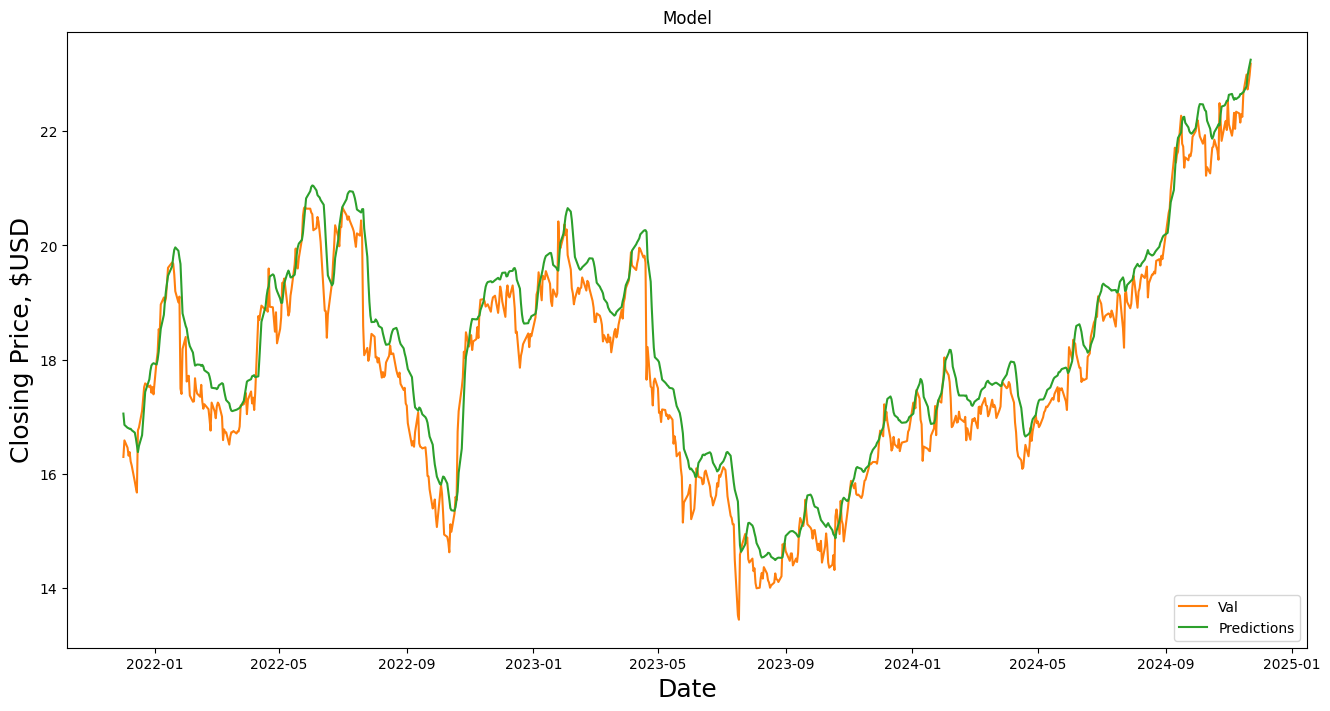

In [ ]:
stock_prediction_pipeline_3 ('T')

In [ ]:
stock_prediction_pipeline_4 = create_pipeline ([
    set_source (source = "stooq", start_date = "2010-01-01"),
    get_closing_price,
    convert_to_numpy_array,
    set_size_of_training_data (percentage = 0.8),
    create_keras_model (model_layers = [LSTM (50, return_sequences = True, input_shape = (60, 1)), LSTM (50, return_sequences = False, input_shape = (60, 1)), Dense (25), Dense (25), Dense (1)]),
    set_model_compiler (optimizer = "adam", loss = "mean_squared_error", metrics = ["mse", "mae", RootMeanSquaredError ()]),
    set_model_batch_and_epoch (batch_size = 10, epochs = 10),
    calculate_predictions,
    evaluate_model,
    plot_prediction_and_y_test
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - loss: 0.0316 - mae: 0.0914 - mse: 0.0316 - root_mean_squared_error: 0.1524
Epoch 2/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - loss: 9.6555e-04 - mae: 0.0225 - mse: 9.6555e-04 - root_mean_squared_error: 0.0310
Epoch 3/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - loss: 7.4560e-04 - mae: 0.0195 - mse: 7.4560e-04 - root_mean_squared_error: 0.0273
Epoch 4/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - loss: 7.8427e-04 - mae: 0.0205 - mse: 7.8427e-04 - root_mean_squared_error: 0.0280
Epoch 5/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - loss: 5.9678e-04 - mae: 0.0179 - mse: 5.9678e-04 - root_mean_squared_error: 0.0244
Epoch 6/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - loss: 5.5041e-04 - mae: 0.0166 - mse: 5.5041e-04 - root_mean_squared_error: 0.0234
Epoch 7/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - loss: 5.4489e-04 - mae: 0.0167 - mse: 5.4489e-04 - root_mean_squared_error: 0.0233
Epoch 8/10
294/294 ━━━━━━━━━━━━━━━━

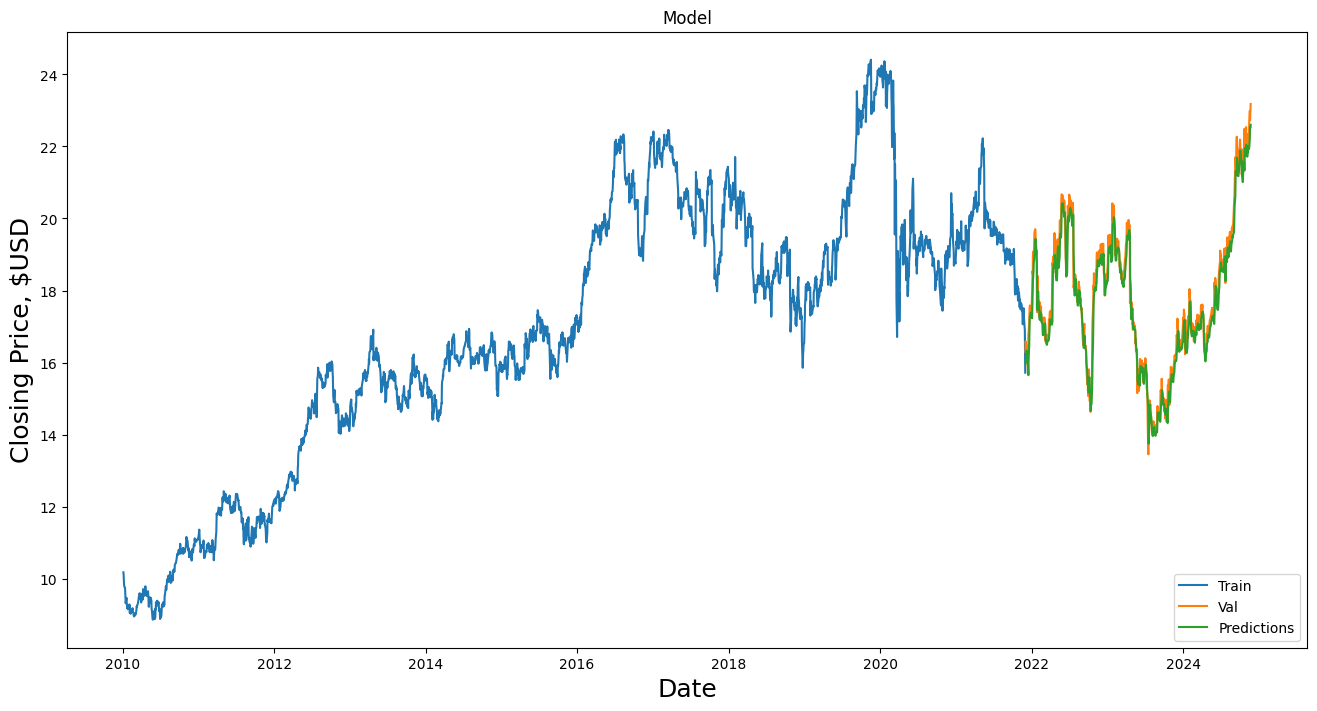

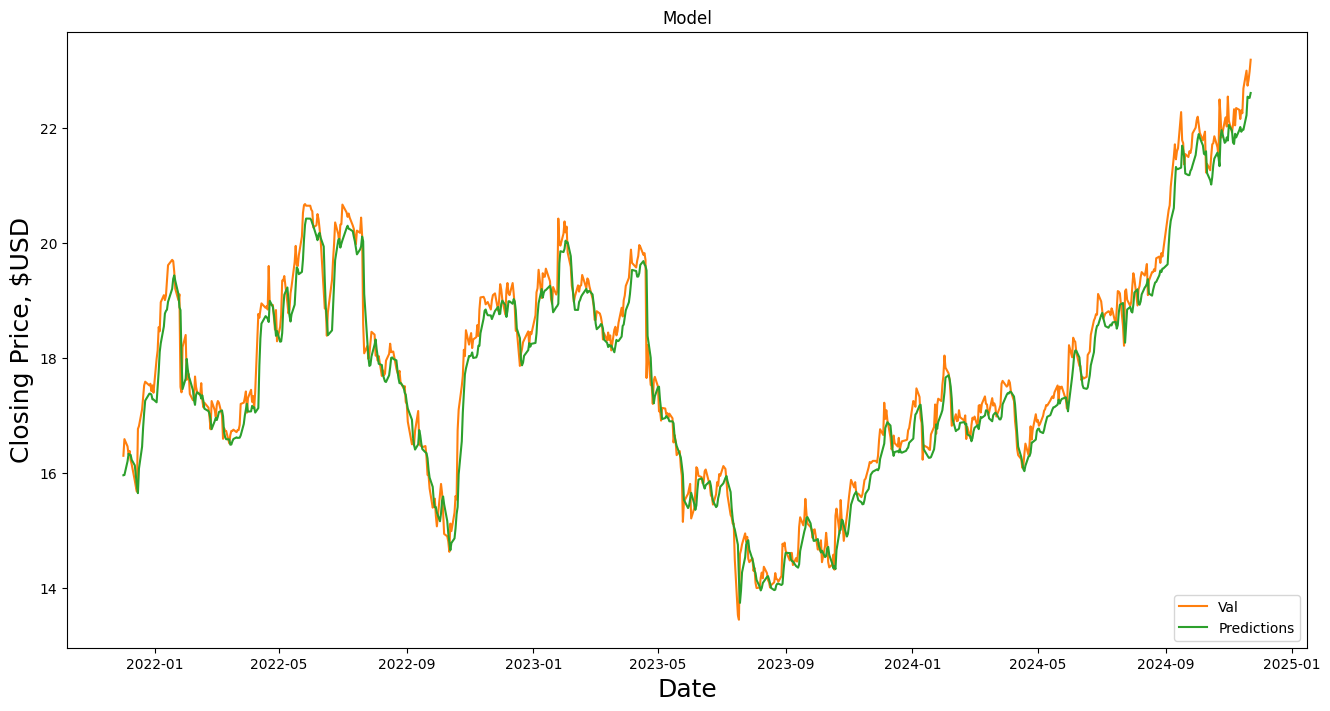

In [ ]:
stock_prediction_pipeline_4 ('T')